# Building a database for crime reports

In this project, we will put everything together to build a database for storing data related to crimes that occurred in Boston. 

1. `incident_number`: identifier of the crime. 
2. `offense_code`: a numeric identifier code for the committed crime. 
3. `description`: a description of the crime. 
4. `date`: the date when the crime happened
5. `day_of_the_week`: the corresponding day of the week. 
6. `lat`: the location of the crime with latitude 
7. `long`: the location of the crime with longitude coordinates.

### The goal of this project:
- Creating **a database** named `crimes_db` with a **table** – `boston_crimes` – with appropriate **datatypes for storing the data** from the `boston.csv` file. 
- Creating the **table** inside a schema named `crimes`. 
- Creating the `readonly` and `readwrite` **groups** with the appropriate privileges, then create **1 user** for each of these groups.

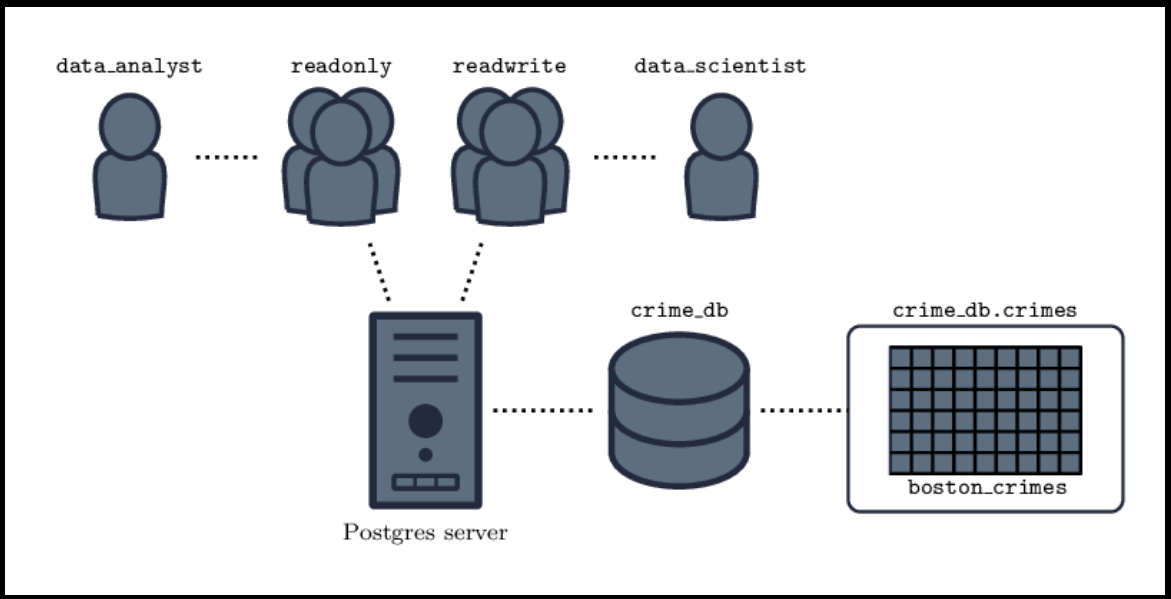

## 1. CREATE DATABSE, AND IT'S SCHEMA

Firstly, Connect to the `dq` database with user `dq`, and create a new database named `crime_db`

In [2]:
import psycopg2
conn = psycopg2.connect("dbname=postgres user=postgres password=postgresql01234")
cur = conn.cursor()

conn.autocommit = True
cur.execute("CREATE DATABASE crime_db")
conn.autocommit = False

conn.close()

Next step is connecting to the `crime_db` with user `dq` and create a schema named `crimes`

In [4]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

cur.execute("CREATE SCHEMA crimes;")

conn.commit()
conn.close()

## 2. Load CSV file to tables on database
We now have a database and a schema — we're ready to start creating tables. Before we do that, let's gather some data about our crime dataset so that we can easily select the right datatypes to use in our table.

**NOTE**: Ghi full path cách nhau = `\\`, để origin name

In [3]:
import csv
with open('C:\\Users\\acer\\Desktop\\Day ta sai an\\SQL\\Postgres\\Building a database for crime reports\\boston.csv', 'r') as file:
    reader = csv.reader(file)
    rows = list(reader)
    col_headers = rows[0]
    first_row = rows[1]
    
#     col_headers = next(reader)
#     first_row = next(reader)

We now have access to the column headers and the first row of data. This will help us when we create the table. We won't have to remember the names of the columns, and using the first row of data, we can easily recall what kind of data is in each column.

In [4]:
print(col_headers)
print(first_row)

['incident_number', 'offense_code', 'description', 'date', 'day_of_the_week', 'lat', 'long']
['1', '619', 'LARCENY ALL OTHERS', '2018-09-02', 'Sunday', '42.35779134', '-71.13937053']


Before we create a table to store the crime data, we need to identify the proper datatypes for the columns. 

Let's create a function — `get_col_set()` — that, given the name of a CSV file and a column index (starting at 0), computes a Python set with all distinct values contained in that column. This function will be useful for two reasons:

1. Checking whether an enumerated datatype might be a good choice for representing a column
2. Computing the maximum length of any text-like column to select appropriate sizes for `VARCHAR` columns

**NOTE**: set() / []: add() / append()

In [5]:
def get_col_set(csv_filename, col_index):
    col_set = set()
    with open(csv_filename, 'r') as file:
        reader = csv.reader(file)
        col_headers = next(reader)
        rows = list(reader)
        for row in rows:
            col = row[col_index]
            if col not in col_set: 
                col_set.add(col)
    return col_set

for i in range(len(col_headers)):
    values = get_col_set("C:\\Users\\acer\\Desktop\\Day ta sai an\\SQL\\Postgres\\Building a database for crime reports\\boston.csv", i)
    print(col_headers[i] + ": " + str(len(values)))


incident_number: 298329
offense_code: 219
description: 239
date: 1177
day_of_the_week: 7
lat: 18177
long: 18177


There are two textual columns in the dataset: `description` and `day_of_the_week`. However, the day of the week contains only seven values — one for each day. We can tell that the longest of them is `Wednesday` without any computation.

`day_of_the_week`Column with a **low number** of distinct values tend to be good candidates for **enumerated datatypes**.

Let's compute the maximum length of each value in the `description` column. To know the longest word in any column containing textual data. We can actually use the previous function for computing this:
1. Use the `get_col_set()` function to get the distinct values of that column into a variable named `col_values`.
2. Iterate over the elements of `col_values`, and find the longest one.

In [6]:
des_values = get_col_set("C:\\Users\\acer\\Desktop\\Day ta sai an\\SQL\\Postgres\\Building a database for crime reports\\boston.csv", 2)
description = 0
for value in des_values:
    if description < len(value):
        description = len(value)
print(description)

58


## 3. CREATE THE TABLE
Before creating a table, we noticed a column suiting to have an enumerated datatype with 7 string values. Therefore, we will first create that enumerated datatype for `day_of_the_week` column:

In [7]:
day_values = get_col_set("C:\\Users\\acer\\Desktop\\Day ta sai an\\SQL\\Postgres\\Building a database for crime reports\\boston.csv", 4)
print(day_values)

{'Tuesday', 'Monday', 'Friday', 'Saturday', 'Wednesday', 'Thursday', 'Sunday'}


Create a table named `boston_crimes` inside the `crimes` schema of the `crime_db` database. The syntax to create `table_name` inside a schema named `schema_name` is as follows:

In [10]:
import psycopg2
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

cur.execute("""
    CREATE TYPE day_of_week AS ENUM 
    ('Tuesday', 
     'Monday', 
     'Friday', 
     'Saturday', 
     'Wednesday', 
     'Thursday', 
     'Sunday');
     """)

conn.commit()
conn.close()

DuplicateObject: type "day_of_week" already exists


In [11]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

cur.execute("""
    CREATE TABLE crimes.boston_crimes (
    incident_number INT PRIMARY KEY,
    offense_code INT,
    description varchar(100),
    date DATE,
    day_of_the_week DAY_OF_WEEK,
    lat DECIMAL,
    long DECIMAL);
    """)

conn.commit()
conn.close()

## 4. Load the data into the table
Now that we have created the table, we can load the data into it by `cursor.copy_expert()` method.

In [13]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

with open("C:\\Users\\acer\\Desktop\\Day ta sai an\\SQL\\Postgres\\Building a database for crime reports\\boston.csv", "r")  as file:
    cur.copy_expert("COPY crimes.boston_crimes FROM STDIN WITH CSV HEADER", file)

conn.commit()
conn.close()

Our database is starting to look good! We have created a database with a schema inside it to hold data about crimes. We selected the right datatypes for storing the data, created a table, and loaded the CSV containing crimes about Boston.

## 5. Create groups, users

Now it's time to handle users. Our goal is to create the two user groups that we have learned about: `readonly` and `readwrite`. By following the least privilege principle, the first step in doing so is to make sure that there are **no privileges** inherited from the `public` group and on the `public` schema.

In [15]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

cur.execute("""
REVOKE ALL ON SCHEMA public FROM public;
REVOKE ALL ON DATABASE crime_db FROM public
""")

conn.commit()
conn.close()

We've made sure that we aren't going to **inadvertently inherit privileges from the `public` group**. The next step is to create our two user groups.

In [16]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

cur.execute("""
CREATE GROUP readonly WITH NOLOGIN;
GRANT CONNECT ON DATABASE crime_db TO readonly;
GRANT USAGE ON SCHEMA crimes TO readonly;
GRANT SELECT ON ALL TABLES IN SCHEMA crimes TO readonly;

CREATE GROUP readwrite WITH NOLOGIN;
GRANT CONNECT ON DATABASE crime_db TO readwrite;
GRANT USAGE ON SCHEMA crimes TO readwrite;
GRANT SELECT, INSERT, DELETE, UPDATE ON ALL TABLES IN SCHEMA crimes TO readwrite;
""")

conn.commit()
conn.close()

We are nearly done with setting up our crime database. The only thing that we need to do is create users. Right now, the high-level picture of our database looks like this:

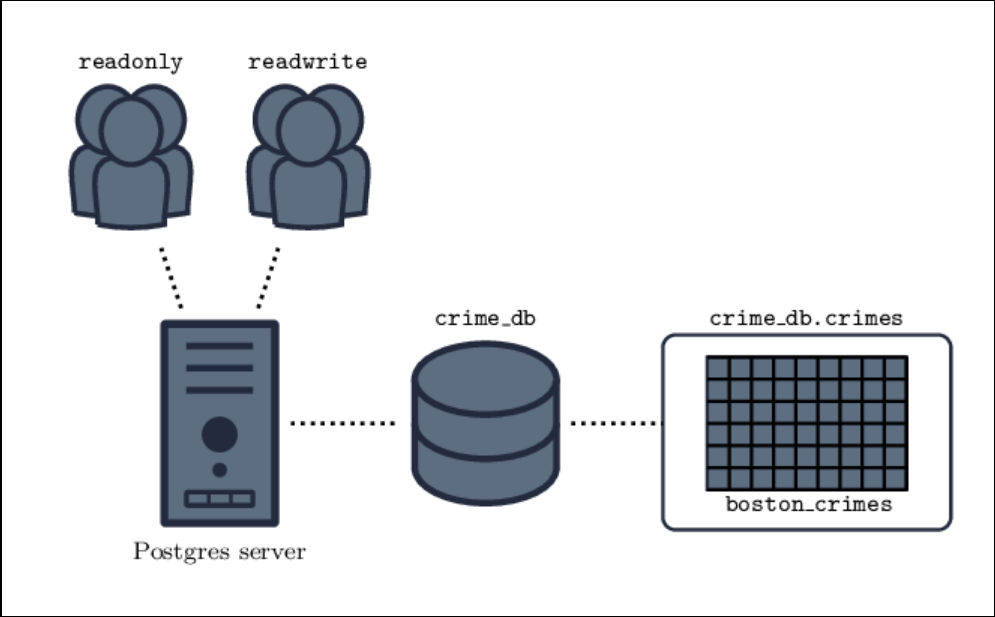

Let's finish the project by creating one user in each group.

In [17]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

cur.execute("""
CREATE USER data_analyst WITH PASSWORD 'secret1';
GRANT readonly TO data_analyst;
CREATE USER data_scientist WITH PASSWORD 'secret2';
GRANT readwrite TO data_scientist;
""")
conn.commit()
conn.close()

Inshort, our database should now look like this:
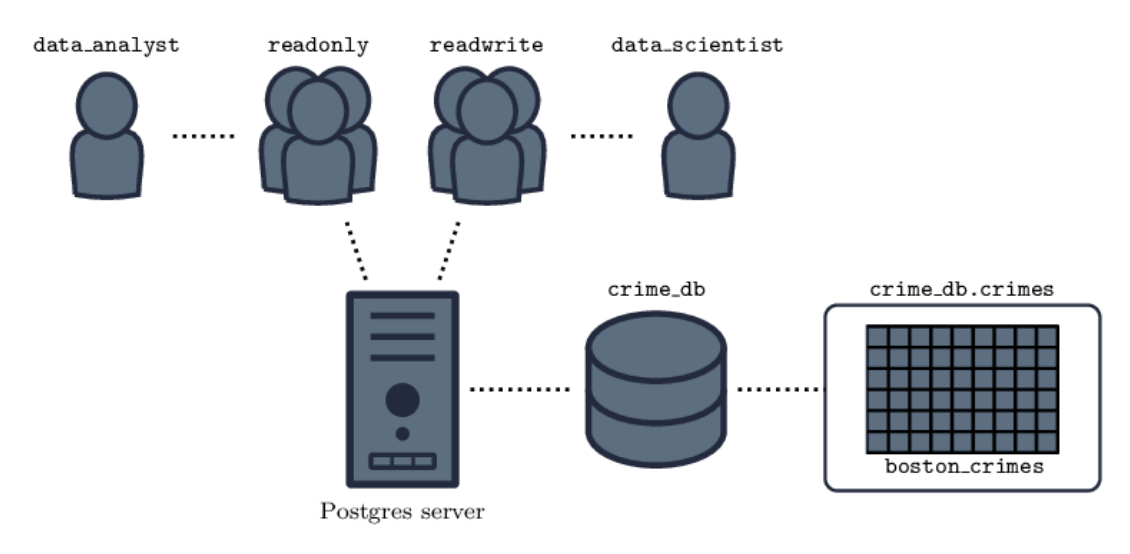

# Test the database setup

Test the database setup using SQL queries on the `pg_roles` table and `information_schema.table_privileges`.

In the `pg_roles` table we will check database related privileges and for that we will look at the following columns:

* rolname: The name of the user / group that the privilege refers to.
* rolsuper: Whether this user / group is a super user. It should be set to `False` on every user / group that we have created.
* rolcreaterole: Whether user / group can create users, groups or roles. It should be `False` on every user / group that we have created.
* rolcreatedb: Whether user / group can create databases. It should be `False` on every user / group that we have created.
* rolcanlogin: Whether user / group can login. It should be `True` on the users and `False` on the groups that we have created.

In the `information_schema.table_privileges` we will check privileges related to SQL queries on tables. We will list the privileges of each group that we have created.

In [31]:
conn = psycopg2.connect("dbname=crime_db user=postgres password=postgresql01234")
cur = conn.cursor()

# check users and groups
cur.execute("""
    SELECT rolname, rolsuper, rolcreaterole, rolcreatedb, rolcanlogin FROM pg_roles
    WHERE rolname IN ('readonly', 'readwrite', 'data_analyst', 'data_scientist');
""")
for user in cur:
    print(user)
print()
# check privileges
cur.execute("""
    SELECT grantee, privilege_type
    FROM information_schema.table_privileges
    WHERE grantee IN ('readonly', 'readwrite');
""")
for user in cur:
    print(user)
conn.close()

('readonly', False, False, False, False)
('readwrite', False, False, False, False)
('data_analyst', False, False, False, True)
('data_scientist', False, False, False, True)

('readonly', 'SELECT')
('readwrite', 'INSERT')
('readwrite', 'SELECT')
('readwrite', 'UPDATE')
('readwrite', 'DELETE')


# Chỉ nên conn.close vào cuối bài hoi, vì mỗi lần close lại phải connect db lại.